<h1>NLP Disaster Tweets Kaggle Mini-Project</h1>

<h2>1. Description of the Problem and Data</h2>

_Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data._

This notebook is a submission for Week 4 of University of Colorado Boulder CSCA 5642: Introduction to Deep Learning. The assignment is a submission in the Kaggle competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview). It includes a dataset of 10,000 hand-classified tweets that either do or do not refer to real disasters in the world. 

The goal is to predict whether a given tweet is about a real disaster or not (if yes, predict 1; if no, predict 0). Real disaster tweets are useful as a first indication that something serious may have gone wrong in some part of the world, but it's important to sort out the tweets that are just people exaggerating or using similar words in a non-urgent way. 

(Side note: my day job is as a journalist and I use a program that does this kind of classification, Dataminr, often in my work!)

The test dataset has 3,263 rows and four columns (id, keyword, location and text of the tweet). The training set has 7,613 rows and those same four columns plus one more, target, which is the binary hand code for whether a tweet indicates a real disaster or not.

We can use natural language processing, a powerful strategy to impute meaning from text strings. We'll start by importing the data and some useful libraries.


In [1]:
!pip3 install keras-core --upgrade
!pip3 install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import math
import pickle
import gzip
import random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

data_train = pd.read_csv('/Users/206509/CU/machine-learning/deep-learning/tweets/train.csv')
data_test = pd.read_csv('/Users/206509/CU/machine-learning/deep-learning/tweets/test.csv')

<h2>2. Exploratory Data Analysis</h2>

_Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?_

We'll start by exploring the training data a bit: see the counts, null counts, head, etc., and see the class distribution between real disaster tweets and non-disaster ones. We'll also look at a few random real and a few random non-disaster tweets to get a feel for what is classified in each category.

In [3]:
print(data_train.info())
print(data_train.isnull().sum())
print(data_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target 

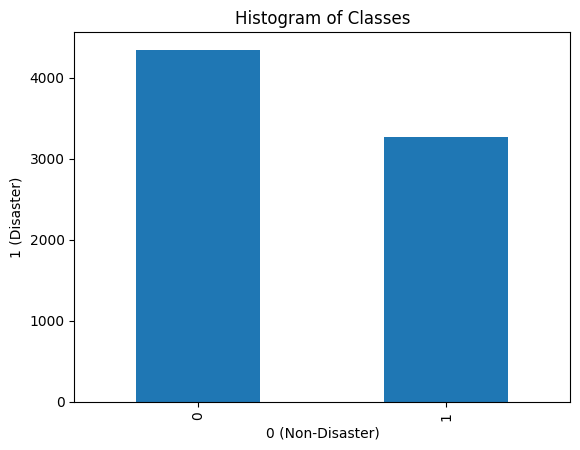

In [4]:
#class distribution histogram
data_train['target'].value_counts().plot(kind='bar')
plt.xlabel('0 (Non-Disaster)')
plt.ylabel('1 (Disaster)')
plt.title(f'Histogram of Classes')
plt.show()

In [5]:
#print a few random disaster and non-disaster tweets
def get_random_tweets(dataframe, column, value, number):
    filtered_df = dataframe.loc[dataframe[column] == value]
    number = min(number, len(filtered_df))
    random_tweets = filtered_df.sample(n=number, random_state=42) 
    return random_tweets

print(f"Random real disaster tweets:\n")
get_random_tweets(data_train, 'target', 1, 5)

Random real disaster tweets:



,id,keyword,location,text,target
4008,5692,floods,North America,Nearly 50 thousand people affected by floods i...,1
325,471,armageddon,"Florida, USA",Vladimir Putin Issues Major Warning But Is It ...,1
1215,1753,buildings%20burning,somewhere over a rainbow,@DoctorFluxx @StefanEJones @spinnellii @themer...,1
494,716,attacked,NaN,Telnet attacked from 124.13.172.40 (STREAMYX-H...,1
2961,4253,drowning,Numa casa de old yellow bricks,LONDON IS DROWNING AND IIII LIVE BY THE RIVEEE...,1


In [6]:
print(f"Random not disaster tweets:\n")
get_random_tweets(data_train, 'target', 0, 5)

Random not disaster tweets:



,id,keyword,location,text,target
3697,5260,fatality,NaN,Everyday is a near death fatality for me on th...,0
4180,5937,hazard,Australia,#Lifestyle Û÷It makes me sickÛª: Baby clothe...,0
4634,6586,inundated,"England & Wales Border, UK",@Lenn_Len Probably. We are inundated with them...,0
6135,8753,siren,"Tampa, FL",A demoness with the voice of an angel. Like a ...,0
4568,6494,injuries,Scottsdale. AZ,Next Man Up---AH SCREW THIS! I'm so tired of i...,0


Cool. It looks like the dataset is pretty well balanced, there are some null values for location and keyword, and these random samples give us a good sense for the kinds of tweets that should and should not be classified as real disaster tweets. We will do a little bit of data cleaning on the "text" column: stripping punctuation and special characters, extra white spaces, plus links, and converting everything to lowercase. We might also think about removing numbers, but I'm going to leave them in for now, in case they're useful for terms like "Category 3 Hurricane."

Let's also use a filler for the NaN values in location and keyword. I think we don't need to discard those rows since the text is the most important thing, but it may mess up our models to have null values.

In [7]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
data_train['text'] = data_train['text'].apply(clean_text)
print(data_train[['text']].head())

                                                text
0  our deeds are the reason of this earthquake ma...
1              forest fire near la ronge sask canada
2  all residents asked to shelter in place are be...
3  13 000 people receive wildfires evacuation ord...
4  just got sent this photo from ruby alaska as s...


<h2>3. Model Architecture</h2>

_Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.  Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report. There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words. Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.)._



For the word embeddings, I'm choosing to use Keras' Tokenizer function rather than another option (TF-IDF, etc.) because it works particularly well with RNNs and we already know we want to use an RNN as our model in this assignment.

Tokenizer transforms text into series of integers, and pad_sequences pads out the array of each tweet as needed so they all end up the same length and can be more easily compared to each other.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU
from sklearn.model_selection import train_test_split

#parameters
max_words = 10000  
max_len = 140

#tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_train['text']) 
X_train_seq = tokenizer.texts_to_sequences(data_train['text'])
X_test_seq = tokenizer.texts_to_sequences(data_test['text'])

#padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

#define real values for y
y_train = data_train['target']

#train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

For the model itself, as stated before, we'll use an RNN. I'm going to start with SimpleRNN just to get a good feel for how it performs, and then we can build in more complexity in later fine-tuning steps.

In [9]:
#create df to store the accuracy values, to compare/contrast them later
results_df = pd.DataFrame(columns=['model_version', 'epochs', 'train_accuracy', 'val_accuracy', 'test_accuracy'])

#start with simple RNN model
model_version = 'Basic_RNN_v1'
epochs = 5

basic_model = Sequential()

#embedding layer
basic_model.add(Embedding(input_dim=max_words, output_dim=128))

#basic RNN layer
basic_model.add(SimpleRNN(64, return_sequences=False))

#output layer
basic_model.add(Dense(1, activation='sigmoid'))

basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

basic_history = basic_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

basic_predictions = basic_model.predict(X_test_padded)

basic_train_accuracy = basic_history.history['accuracy'][-1]  # Last epoch accuracy
basic_val_accuracy = basic_history.history['val_accuracy'][-1]  # Last epoch validation accuracy

#add results to df
new_row = pd.DataFrame({
    'model_version': [model_version], 'epochs': [epochs], 
    'train_accuracy': [basic_train_accuracy], 'val_accuracy': [basic_val_accuracy]})

#add the new row to the results df
results_df = pd.concat([results_df, new_row], ignore_index=True)


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6117 - loss: 0.6482 - val_accuracy: 0.7768 - val_loss: 0.4980
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8851 - loss: 0.3081 - val_accuracy: 0.6448 - val_loss: 1.0063
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8589 - loss: 0.3340 - val_accuracy: 0.7492 - val_loss: 0.5802
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9686 - loss: 0.1068 - val_accuracy: 0.7715 - val_loss: 0.6033
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9806 - loss: 0.0624 - val_accuracy: 0.7472 - val_loss: 0.6449
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/var/folders/nm/y2b7kss92gg4y3x0wyzjmhh00000gq/T/ipykernel_72008/3192496754.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


<h2>4. Results and Analysis</h2>

_Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped. Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.__

The first, most basic RNN did really well — 98 percent accuracy on the training set, and 74 percent on the validation set. Let's visualize that result and then do some architecture and hyperparameter tweaking.

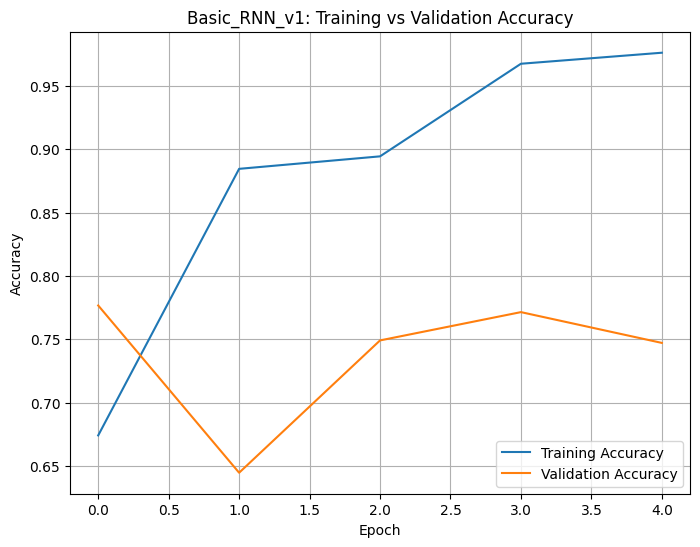

In [16]:
#plot training and validation accuracy
def plot_accuracy(history, model_version):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'{model_version}: Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_accuracy(basic_history, model_version='Basic_RNN_v1')

This is a good start! It would be great to get the validation accuracy up, though. Let's try making the RNN a bit more complex — we can use an LSTM layer, which is really helpful for sequential data. Although something like a tweet is not a time sequence, per se, sentences are sequential and it will be handy to store past values in memory.

In [11]:
model_version = 'LSTM'
epochs = 5

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128))

#lstm layer
lstm_model.add(LSTM(128)) 
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))
lstm_predictions = lstm_model.predict(X_test_padded)

lstm_train_accuracy = lstm_history.history['accuracy'][-1]  # Last epoch accuracy
lstm_val_accuracy = lstm_history.history['val_accuracy'][-1]  # Last epoch validation accuracy

#add results to df
new_row = pd.DataFrame({
    'model_version': [model_version], 'epochs': [epochs], 
    'train_accuracy': [lstm_train_accuracy], 'val_accuracy': [lstm_val_accuracy]})

#add the new row to the results df
results_df = pd.concat([results_df, new_row], ignore_index=True)


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.6333 - loss: 0.6260 - val_accuracy: 0.7886 - val_loss: 0.4662
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.8707 - loss: 0.3264 - val_accuracy: 0.7800 - val_loss: 0.4705
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9194 - loss: 0.2218 - val_accuracy: 0.7768 - val_loss: 0.5392
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9448 - loss: 0.1554 - val_accuracy: 0.7656 - val_loss: 0.6310
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9655 - loss: 0.1084 - val_accuracy: 0.7479 - val_loss: 0.7757
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


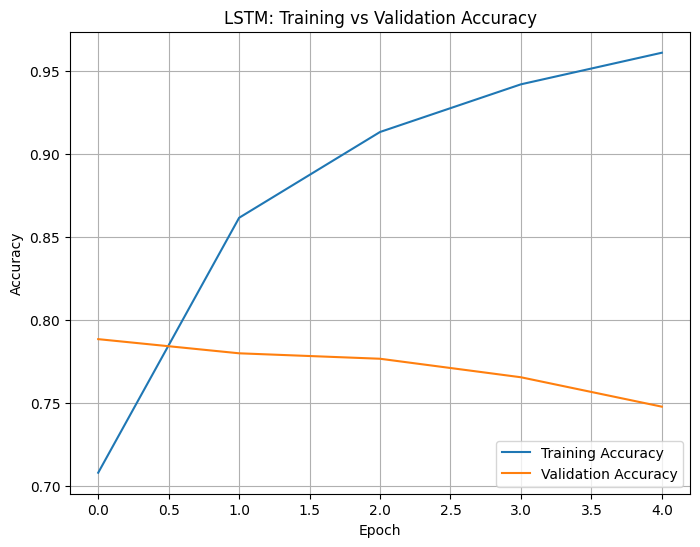

In [12]:
plot_accuracy(lstm_history, model_version='LSTM')

Hmm. This is in the same general arena as our simple model, but I'm not certain it converged. Let's try it again with more epochs …

In [13]:
model_version = 'LSTM_v_2'
epochs = 10

lstm_2_model = Sequential()
lstm_2_model.add(Embedding(input_dim=max_words, output_dim=128))

#lstm layer
lstm_2_model.add(LSTM(128)) 
lstm_2_model.add(Dense(1, activation='sigmoid'))
lstm_2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_2_history = lstm_2_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))
lstm_2_predictions = lstm_2_model.predict(X_test_padded)

lstm_2_train_accuracy = lstm_2_history.history['accuracy'][-1]  # Last epoch accuracy
lstm_2_val_accuracy = lstm_2_history.history['val_accuracy'][-1]  # Last epoch validation accuracy

#add results to df
new_row = pd.DataFrame({
    'model_version': [model_version], 'epochs': [epochs], 
    'train_accuracy': [lstm_2_train_accuracy], 'val_accuracy': [lstm_2_val_accuracy]})

#add the new row to the results df
results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6299 - loss: 0.6265 - val_accuracy: 0.8037 - val_loss: 0.4560
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.8609 - loss: 0.3353 - val_accuracy: 0.7899 - val_loss: 0.4921
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9223 - loss: 0.2055 - val_accuracy: 0.7695 - val_loss: 0.5656
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9442 - loss: 0.1574 - val_accuracy: 0.7597 - val_loss: 0.6504
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9674 - loss: 0.1057 - val_accuracy: 0.7571 - val_loss: 0.7049
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9692 - loss: 0.0918 - val_accuracy: 0.7531 - val_loss: 0.8348
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.9769 - loss: 0.0708 - val_accuracy: 0.7466 - val_loss: 0.8939
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9769 - loss: 0.0582 - val_accu

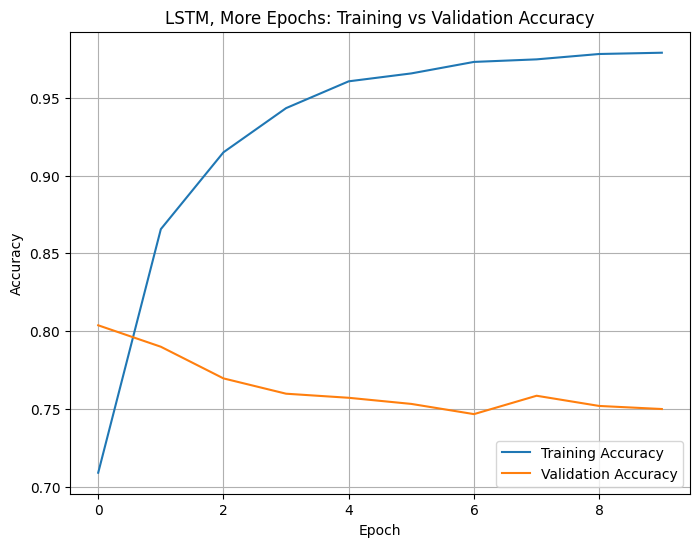

In [14]:
plot_accuracy(lstm_2_history, model_version='LSTM, More Epochs')

Nice, a bit higher even. This is definitely a contender. Let's try one other architecture option — using a GRU instead of an LSTM. GRUs are similar to LSTMs in that they take sequential data into account, but they're more computationally efficient because they use update and reset gates. So I think I could experiment with a lower learning rate but the same number of epochs. We'll also add a dropout layer this time because the validation accuracy decreasing in the two LSTM versions made me feel a bit wary of overfitting.

In [18]:
model_version = 'GRU'
epochs = 10

gru_model = Sequential()
gru_model.add(Embedding(input_dim=max_words, output_dim=128))

#new gru layer
gru_model.add(GRU(64, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


gru_history = gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

gru_train_accuracy = gru_history.history['accuracy'][-1]  # Last epoch accuracy
gru_val_accuracy = gru_history.history['val_accuracy'][-1]  # Last epoch validation accuracy

#add results to df
new_row = pd.DataFrame({
    'model_version': [model_version], 'epochs': [epochs], 
    'train_accuracy': [gru_train_accuracy], 'val_accuracy': [gru_val_accuracy]})

#add the new row to the results df
results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6118 - loss: 0.6504 - val_accuracy: 0.7820 - val_loss: 0.4743
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8578 - loss: 0.3395 - val_accuracy: 0.7833 - val_loss: 0.4921
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9091 - loss: 0.2276 - val_accuracy: 0.7531 - val_loss: 0.5709
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9495 - loss: 0.1508 - val_accuracy: 0.7584 - val_loss: 0.6485
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9646 - loss: 0.1094 - val_accuracy: 0.7577 - val_loss: 0.7896
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9756 - loss: 0.0760 - val_accuracy: 0.7531 - val_loss: 0.7817
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9781 - loss: 0.0703 - val_accuracy: 0.7656 - val_loss: 0.9130
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9776 - loss: 0.0593 - val_accuracy: 0.7557 - v

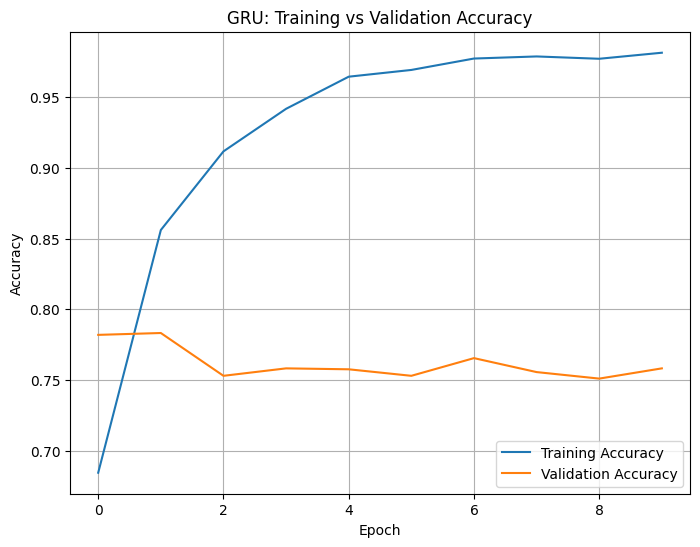

In [20]:
plot_accuracy(gru_history, model_version='GRU')

Wow, is there a Minions movie in here? Because I think we've just witnessed The Rise of GRU. It performed admirably, and we'll use it on our test set for the Kaggle submission. But first, a quick summary of everything we tried:

In [21]:
print(results_df)

  model_version epochs  train_accuracy  val_accuracy test_accuracy
0  Basic_RNN_v1      5        0.976190      0.747209           NaN
1          LSTM      5        0.961248      0.747866           NaN
2      LSTM_v_2     10        0.978982      0.749836           NaN
3           GRU     10        0.981117      0.758372           NaN


In [22]:
#using the model on the test df for the kaggle submission
X_test_seq = tokenizer.texts_to_sequences(data_test['text'])
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

#make predictions
predictions = gru_model.predict(X_test_padded)

#convert probabilities to binary predictions (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

#create a df for the results
results = pd.DataFrame({'id': data_test['id'], 'target': predicted_classes.flatten()})

results.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Predictions saved to predictions.csv


<h2>5. Discussion and Conclusion</h2>

_Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?_

I was really surprised that all the model versions performed really well on the training sets, even with a relatively small number of epochs! I think any of these would be fine to submit. I'm not surprised GRU did the best of all, though — it's a more efficient way of handling sequential data in an RNN than an LSTM model is.

My submission for the test set garnered a score of .75819, and a leaderboard position of 847th. (Not amazing, but not dead last, I guess?!) I'm not surprised that was the score given how this model (and all the others) performed on the validation set.

I think the best way I could improve this project in the future would be to investigate and try to close that gap between the very high training scores I got on all four models and the relatively middling validation (and ultimately test) scores. I think all of these models were overfitting to one extent or another. Maybe some combination of adding more dropout layers and L2 regularization, or fewer units, might help.

<h2>6. References</h2>

[Keras NLP: Getting Started](https://keras.io/guides/keras_nlp/getting_started/)

[KerasNLP Starter Notebook Disaster Tweets](https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets)

[Natural Language Processing explanation from DeepLearning.AI](https://www.deeplearning.ai/resources/)

[Understanding RNN and LSTM](https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e)

[Gated Recurrent Unit](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/gated-recurrent-unit)